In [14]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [15]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]
(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [16]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)
[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [17]:
# label.shape = (num_sample, 1)
train_dataset = xgb.DMatrix(data=X_train, label=y_train_enc)
val_dataset = xgb.DMatrix(data=X_va, label=y_va_enc)
test_dataset = xgb.DMatrix(data=X_test)

In [18]:
params = {'objective': 'multi:softprob',
          "eval_metric": 'mlogloss',
           "verbosity": 0,
          'num_class': 7}

# train_dataset的名称为train_,val_dataset的名称定义为val_
eval_set = [(train_dataset, "train_"), (val_dataset, "val_")]
evals_result = {}  # 储存评估指标(内置和自定义)结果

In [19]:
from sklearn.metrics import log_loss


def my_xgb_loss(y_pred, y_true):
    """xgboost自定义验证数据集损失函数格式"""
    loss = log_loss(y_true.get_label(), y_pred)
    return 'MY_GBM_LOSS', loss

In [20]:
model = xgb.train(params=params,
                  dtrain=train_dataset,
                  # num_boost_round (int) – Number of boosting iterations.
                  # 默认num_boost_round=10
                  num_boost_round=200,
                  # List of validation sets for which metrics will evaluated during training.
                  evals=eval_set,
                  early_stopping_rounds=100,
                  # verbose_eval (bool or int) – Requires at least one item in evals.
                  # If verbose_eval is True then the evaluation metric on the validation set is printed at each boosting stage.
                  # If verbose_eval is an integer then the evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
                  # The last boosting stage / the boosting stage found by using
                  verbose_eval=20,  # 默认verbose_eval=True
                  evals_result=evals_result,
                  feval=my_xgb_loss,
                  )

[0]	train_-mlogloss:1.35022	train_-MY_GBM_LOSS:1.25191	val_-mlogloss:1.41993	val_-MY_GBM_LOSS:1.32454
[20]	train_-mlogloss:0.18123	train_-MY_GBM_LOSS:0.41508	val_-mlogloss:0.43417	val_-MY_GBM_LOSS:0.99281
[40]	train_-mlogloss:0.07562	train_-MY_GBM_LOSS:0.31988	val_-mlogloss:0.40780	val_-MY_GBM_LOSS:1.42046
[60]	train_-mlogloss:0.03948	train_-MY_GBM_LOSS:0.25873	val_-mlogloss:0.40908	val_-MY_GBM_LOSS:1.58102
[80]	train_-mlogloss:0.02362	train_-MY_GBM_LOSS:0.21777	val_-mlogloss:0.41752	val_-MY_GBM_LOSS:1.62400
[100]	train_-mlogloss:0.01569	train_-MY_GBM_LOSS:0.18720	val_-mlogloss:0.43096	val_-MY_GBM_LOSS:1.79855
[101]	train_-mlogloss:0.01539	train_-MY_GBM_LOSS:0.18498	val_-mlogloss:0.43115	val_-MY_GBM_LOSS:1.84613
[0]	train_-mlogloss:1.34176	train_-MY_GBM_LOSS:1.24216	val_-mlogloss:1.41814	val_-MY_GBM_LOSS:1.33191
[20]	train_-mlogloss:0.17424	train_-MY_GBM_LOSS:0.41082	val_-mlogloss:0.47396	val_-MY_GBM_LOSS:1.29006
[40]	train_-mlogloss:0.07307	train_-MY_GBM_LOSS:0.32189	val_-mlogloss:0.4

In [21]:
# 预测结果为概率向量(多分类)
# test_dataset:The dmatrix storing the input
model.predict(test_dataset)

array([[1.7099640e-01, 8.2841283e-01, 6.7648034e-05, ..., 4.9099435e-05,
        6.2008745e-05, 3.4433900e-04],
       [5.6625727e-06, 1.6236219e-04, 4.1600051e-06, ..., 9.9982303e-01,
        2.2134809e-06, 1.1657530e-06],
       [5.0266044e-05, 1.7302494e-03, 4.5938141e-06, ..., 9.9712807e-01,
        1.0621571e-03, 1.9315796e-05],
       ...,
       [2.3479856e-04, 8.5492553e-05, 2.1853202e-04, ..., 3.6652251e-05,
        2.1747753e-04, 1.9833900e-05],
       [4.1106730e-03, 9.7734624e-01, 1.8623570e-04, ..., 1.7687306e-02,
        8.9562556e-05, 4.9982220e-04],
       [2.5070153e-02, 9.7316951e-01, 3.4052381e-04, ..., 9.0616284e-04,
        2.4198853e-04, 1.6862231e-04]], dtype=float32)

array([[9.9499583e-01, 3.8703645e-03, 6.1613347e-05, ..., 7.6008066e-05,
        7.4151605e-05, 8.5610343e-04],
       [2.8658479e-03, 1.2616834e-04, 2.6256796e-06, ..., 1.8971232e-05,
        4.2828901e-06, 9.9697125e-01],
       [5.3859584e-04, 4.7261000e-01, 9.8786091e-05, ..., 5.2589989e-01,
        6.2348241e-05, 6.8565481e-04],
       ...,
       [1.6815769e-02, 1.7907791e-01, 2.0847151e-04, ..., 8.0360675e-01,
        3.9518047e-05, 1.4998393e-04],
       [5.0533756e-05, 4.3793800e-05, 2.2775579e-04, ..., 1.3138703e-05,
        1.6791881e-04, 1.0688425e-05],
       [9.9687153e-01, 3.0508351e-03, 5.0417257e-06, ..., 7.2445996e-06,
        9.2501268e-06, 4.9410402e-05]], dtype=float32)

In [22]:
evals_result

{'train_': OrderedDict([('mlogloss',
               [1.350219,
                1.066378,
                0.868229,
                0.735486,
                0.632113,
                0.554072,
                0.491422,
                0.439493,
                0.396559,
                0.360688,
                0.333048,
                0.307274,
                0.287924,
                0.267955,
                0.252601,
                0.238184,
                0.228481,
                0.215391,
                0.202593,
                0.193955,
                0.181232,
                0.173817,
                0.164025,
                0.153385,
                0.144208,
                0.135637,
                0.129199,
                0.122704,
                0.118826,
                0.112904,
                0.109075,
                0.103571,
                0.099762,
                0.094697,
                0.09129,
                0.088928,
                0.086024,
  

{'train_': OrderedDict([('mlogloss',
               [1.341762,
                1.04469,
                0.855435,
                0.718941,
                0.615944,
                0.53529,
                0.474056,
                0.423031,
                0.380043,
                0.347413,
                0.322444,
                0.295722,
                0.274565,
                0.258101,
                0.241884,
                0.227586,
                0.216157,
                0.202561,
                0.194862,
                0.18466,
                0.174236,
                0.168346,
                0.161357,
                0.153142,
                0.147943,
                0.14155,
                0.135965,
                0.128987,
                0.124745,
                0.11819,
                0.113851,
                0.106731,
                0.102352,
                0.095363,
                0.091329,
                0.089085,
                0.086926,
      

In [23]:
evals_result['train_'].keys()

odict_keys(['mlogloss', 'MY_GBM_LOSS'])

odict_keys(['mlogloss', 'MY_GBM_LOSS'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

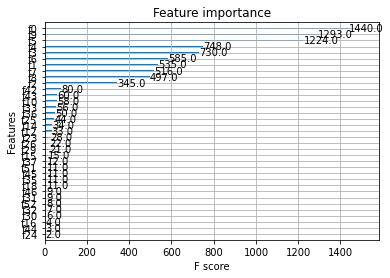

In [28]:
# 绘制特征的相对重要性
xgb.plot_importance(model)

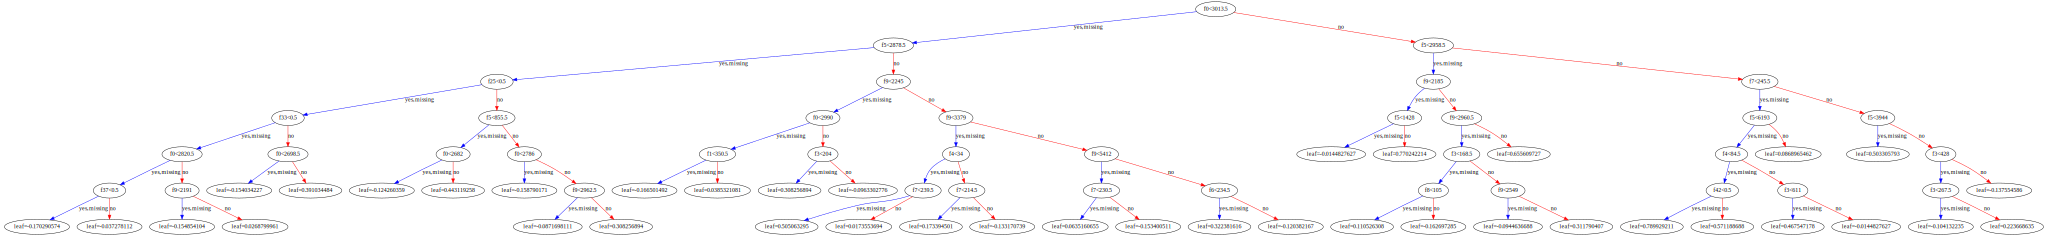

In [27]:
# 可视化lgb分割过程
img = xgb.to_graphviz(model)
img

In [26]:
# 数据类型graphviz.files.Source
type(img)

graphviz.sources.Source

graphviz.sources.Source